## Import data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB


# Load data
B = pd.read_csv('data/B (power transfer factor of each bus to each line).csv', sep=';').values
P_max = pd.read_csv('data\Maximum production of generating units.csv').values
P_min = pd.read_csv('data\Minimum production of generating units.csv').values
min_downtime = pd.read_csv('data\Minimum down time of generating units.csv').values
min_uptime = pd.read_csv('data\Minimum up time of generating units.csv').values
C_g = pd.read_csv('data\Production cost of generating units.csv').values
C_gs = pd.read_csv('data\Start-up cost of generating units.csv').values
ramp = pd.read_csv('data\Ramping rate of generating units.csv').values
F = pd.read_csv('data\Transmission capacity of lines.csv').values

# Load wind data
W_cap = pd.read_csv('data/Capacity of wind farms.csv')
W1 = pd.read_csv('data\W1.csv', skiprows=3) 
W2 = pd.read_csv('data\W2.csv', skiprows=3)

# Scale wind data
W1 = np.array(W1.iloc[:,2]) * W_cap.values[0]
W2 = np.array(W2.iloc[:,2]) * W_cap.values[1]
W = np.vstack((W1, W2)).T

# Remove first row to fit with demand data
Wind = W[1:]

# Load demand data
D = pd.read_csv('data\ConsumptionPerGridarea.csv', sep=';', decimal=',')
D = D.loc[D['GridCompany'].isin([131, 344, 16])]
D["HourDK"] = pd.to_datetime(D["HourDK"])
D = D.loc[D["HourDK"].dt.year == 2021]
D = D.pivot_table(index = "HourDK", columns = "GridCompany", values = "FlexSettledConsumption")

# Read and scale demand data
D_cap = pd.read_csv('data\Loads.csv')
D = (D/np.max(D, axis=0)) * D_cap.values.T
Demand = D.values





## Task 1: Understanding Unit Commitment and optimization model
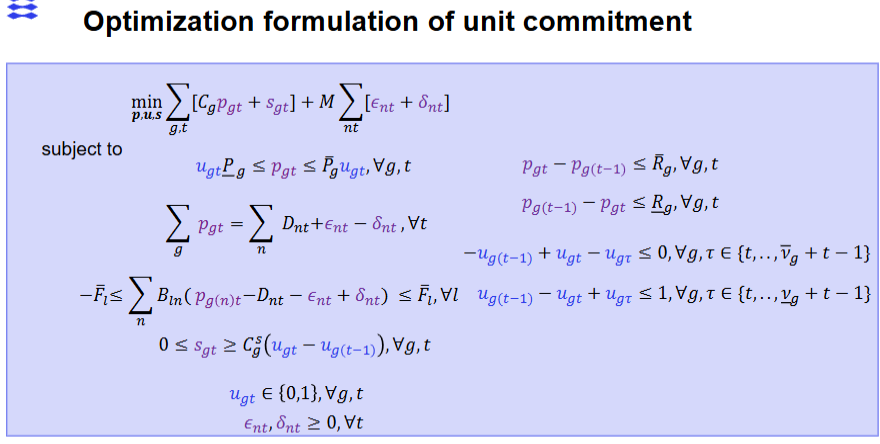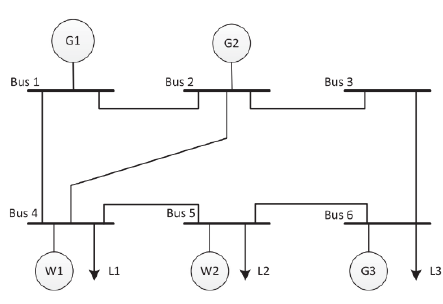

In [ ]:
#### Create model ####
model = gp.Model()

### Parameters ###
G = len(P_max) # number of generators
T, D = Demand.shape # number of time periods
L = len(F) # number of lines
N = B.shape[1] # number of nodes
W = Wind.shape[1] # number of wind farms
G_n = [[0],[1],[],[],[],[2]]
W_n = [[],[],[],[0],[1],[]]
D_n = [[],[],[],[0],[1],[2]]



#### Decision variables ####


# Production/bid in DA market
p_g = model.addVars(G,T, lb = 0, ub = P_max, vtype=GRB.CONTINUOUS, name="p_gt") # Power production in each generator in each time period
p_w = model.addVars(W,T, vtype=GRB.CONTINUOUS, name="p_wt") # Power production in each wind farm in each time period
u = model.addVars(G,T,vtype=GRB.BINARY, name="u_gt") # Binary variable for each generator in each time period
s = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="s_gt") # Start up cost for each generator in each time period

# Slack variables
delta   = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="delta") # Slack variable for each time period for each node
epsilon = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="epsilon") # Slack variable for each time period for each node

#### Objective function ####
# Assume no production cost for wind
model.setObjective(gp.quicksum(C_g[g] * p_g[g,t] + s[g,t] for g in range(G) for t in range(T))
                   + gp.quicksum(delta[n,t] + epsilon[n,t] for n in range(N) for t in range(T)),
                     GRB.MINIMIZE)

### Constraints ###
# Minimum production
model.addConstrs(u[g,t] * P_min[g] <= p_g[g,t] for g in range(G) for t in range(T))

# Maximum production
model.addConstrs(p[g,t] <= u[g,t] * P_max[g] for g in range(G) for t in range(T))

# Power balance
model.addConstrs((gp.quicksum(p_g[g,t] for g in range(G) for t in range(T)) == 
                  gp.quicksum(D[n][t] + epsilon[n,t] - delta[n,t] for t in range(D)) for t in range(T)), "Power balance")

# Line flow
model.addConstrs((gp.quicksum(B[l,n]*(p[g,t] - D[n,t] - epsilon[n,t] + delta[n,t]) for n in range(N)) >= -F[l] for t in range(T) for l in range(L)), "Line flow")
model.addConstrs((gp.quicksum(B[l,n]*(p[g,t] - D[n,t] - epsilon[n,t] + delta[n,t]) for n in range(N)) <= F[l] for t in range(T) for l in range(L)), "Line flow")
                 


array([[ 0.        , -0.68196724, -0.65018141, -0.48266148, -0.51444731,
        -0.63471803],
       [ 0.        ,  0.14604301, -0.75311361, -0.22164175, -0.32248513,
        -0.70405467],
       [ 0.        , -0.31803276, -0.34981859, -0.51733852, -0.48555269,
        -0.36528197],
       [ 0.        ,  0.17198974,  0.1029322 , -0.26101973, -0.19196218,
         0.06933664],
       [ 0.        , -0.14604301, -0.24688639,  0.22164175, -0.67751487,
        -0.29594533],
       [ 0.        , -0.14604301, -0.24688639,  0.22164175,  0.32248513,
        -0.29594533],
       [ 0.        ,  0.14604301,  0.24688639, -0.22164175, -0.32248513,
        -0.70405467]])

## Task 2: Data preperation

In [ ]:
# Split into training, validation and test sets
train_test_fraction = 0.8
train_val_fraction = 0.8
n = len(W1)
train_test_split = int(n * train_test_fraction)
train_val_split = int(train_test_split * train_val_fraction)

D_train = D[:train_test_split]
D_train_train = D[:train_val_split]
D_val = D_train[train_val_split:]
D_test = D[train_test_split:]

W_train = W[:train_test_split]
W_train_train = W[:train_val_split]
W_val = W_train[train_val_split:]
W_test = W[train_test_split:]


## Task 3: Train classifiers

In [ ]:
# Train classifier


array([[25.07423784, 55.12019576, 56.95618532],
       [23.8187883 , 52.50223829, 54.88102191],
       [21.72655341, 49.41647916, 51.9030076 ],
       ...,
       [28.71189202, 60.19854386, 60.01307187],
       [27.39236677, 56.44214136, 56.30035845],
       [25.54774649, 53.83798372, 53.47418693]])

## Task 4: Evaluate models